# Udacity Self-Driving Car Nano Degree - Project 1

## Finding Lane Lines on the Road
---
## Reflection
One design goal for my pipeline was to be independent of the color of the lane markers due to concerns about robustness to lighting conditions, such as during dawn/dusk and night driving.  However, I eventually found it to be necessary to use color masking to get good performance in the provided "sunny day" data.


### Robustness improvements
There is no protection for conditions that would lead to zero length *slope* and *xint*.  This can lead to crash (NaN).

The predicted lane markers depend on the chosen initial parameters and the filters take time to get to the best value.  This can lead to wrongly predicted lines at startup of the single image data and the video data.


### Additional improvements
N-dim Kalman: Due to time constraints, I am using 4 1D Kalman filters with common parameters for process and measurement variance.  The estimator should be improved by using independent variance parameters for the calculated states.  This could also improve the startup issues mentioned in the above section.

Generalize the steps within the edges_to_lanemarkers function to improve the code tuning, debugging, and maintenance.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

In [2]:
def color_threshold(img, red_threshold = 0, green_threshold = 0, blue_threshold = 0):

    color_select = np.copy(img)
    
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Identify pixels below the threshold
    thresholds = (img[:,:,0] < rgb_threshold[0]) \
            | (img[:,:,1] < rgb_threshold[1]) \
            | (img[:,:,2] < rgb_threshold[2])

    color_select[thresholds] = [0,0,0]
    
    return color_select

def equalize(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    return img_output
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold = 70, high_threshold = 140):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho=1, theta = np.pi/180, threshold = 5, min_line_len = 20, max_line_gap = 10):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return lines, line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [3]:
#some helper functions

def getSlope(x1, y1, x2, y2):
    return (y2-y1)/(x2-x1)

def getYIntercept(x1, y1, x2, y2):
    s = getSlope(x1, y1, x2, y2)
    return y1 - s * x1

def getXIntercept(x1, y1, x2, y2, ymax):
    #Rearrange y = -m*x + b to get x = -y/m + b/m
    m = getSlope(x1, y1, x2, y2)
    b = getYIntercept(x1, y1, x2, y2)
    return (ymax/m - b / m)

def getX(y1, y2, m, x1):
    return ( ((y2-y1)/m) + x1)

In [17]:
def kalman(xhat, P, z):
    """
    I unashamedly lifted this basic recipe from:
    http://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html
    """

    # kalman parameters
    Q = 1e-4 # process variance
    R = 0.1**2 # estimate of measurement variance, change to see effect
    
    # time update
    xhatminus = xhat
    Pminus = P+Q

    # measurement update
    K = Pminus/( Pminus+R )
    xhat = xhatminus+K*(z-xhatminus)
    P = (1-K)*Pminus
    
    return xhat, P

In [18]:
global kalman_slope_left, kalman_P1_left, kalman_xint_left, kalman_P2_left
global kalman_slope_right, kalman_P1_right, kalman_xint_right, kalman_P2_right

#initial guess
kalman_slope_left = -0.7
kalman_P1_left = 1E-2
kalman_xint_left =  170
kalman_P2_left = 1E-2

kalman_slope_right = 0.7
kalman_P1_right = 1E-2
kalman_xint_right =  850
kalman_P2_right = 1E-2

In [19]:
def edges_to_lanemarkers(image):
    global kalman_slope_left, kalman_P1_left, kalman_xint_left, kalman_P2_left
    global kalman_slope_right, kalman_P1_right, kalman_xint_right, kalman_P2_right
    
    height, width = image.shape
        
    #roi masks
    leftROIvertices = np.array([[(0, height),                    # bottom left (x, y)
                          (width/2, height/1.8),                 # top left
                          (width/2, height/1.8),                 # top right
                          (width/3, height)]], dtype=np.int32)   # bottom right
    rightROIvertices = np.array([[(width/3, height),             # bottom left (x, y)
                          (width/2, height/1.8),                 # top left
                          (width/2, height/1.8),                 # top right
                          (width, height)]], dtype=np.int32)     # bottom right
    
    
    ########
    # LEFT #
    IMGroi = region_of_interest(image, leftROIvertices)
    
    LEFTlines, IMGHough = hough_lines(IMGroi, threshold = 15)

    #calculate slope and x-intercept of each Hough line
    slope=[]
    xint=[]
    for line in LEFTlines:
        for x1,y1,x2,y2 in line:
            slope = np.append(slope, getSlope(x1, y1, x2, y2))
            xint = np.append(xint, getXIntercept(x1, y1, x2, y2, height))
            
    #remove NaNs
    xint = xint[np.logical_not(np.isnan(slope))]
    slope = slope[np.logical_not(np.isnan(slope))]
    slope = slope[np.logical_not(np.isnan(xint))]
    xint = xint[np.logical_not(np.isnan(xint))]

    #remove wrong slope
    xint = xint[slope<-0.5]
    slope = slope[slope<-0.5]
    
    # Kalman filters to smooth the inputs for the line calculation
    target = np.median(slope)
    kalman_slope_left, kalman_P1_left = kalman(kalman_slope_left, kalman_P1_left, target)
    target = np.median(xint)   
    kalman_xint_left, kalman_P2_left = kalman(kalman_xint_left, kalman_P2_left, target)

    #print(xint, slope, kalman_slope_left, kalman_P1_left, kalman_xint_left, kalman_P2_left)
    
    # Calculate a line with the calculated slope and x-intercept
    line_img = np.zeros((*image.shape, 3), dtype=np.uint8)
    cv2.line(line_img, (int(kalman_xint_left), height), 
                       (int(getX(height, height/1.6, kalman_slope_left, kalman_xint_left)), int(height/1.6)), 
                        [255, 0, 0], 5)    
    
    # Annotate the image
    cv2.putText(line_img, 'Slope: {0:.2f}'.format(kalman_slope_left), org=(0, height-30), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(0,255,0)) 
    cv2.putText(line_img, 'X-int: {0:.2f}'.format(kalman_xint_left), org=(0, height-0), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(0,255,0))     
    
    #########    
    # RIGHT #
    IMGroi = region_of_interest(image, rightROIvertices)
    
    RIGHTlines, _ = hough_lines(IMGroi, threshold = 15)

    #calculate slopeand x-intercept of each Hough line
    slope=[]
    xint=[]
    for line in RIGHTlines:
        for x1,y1,x2,y2 in line:
            slope = np.append(slope, getSlope(x1, y1, x2, y2))
            xint = np.append(xint, getXIntercept(x1, y1, x2, y2, height))
            
    #remove NaNs
    xint = xint[np.logical_not(np.isnan(slope))]
    slope = slope[np.logical_not(np.isnan(slope))]
    slope = slope[np.logical_not(np.isnan(xint))]
    xint = xint[np.logical_not(np.isnan(xint))]
    
    #remove wrong slope
    xint = xint[slope>0.5]
    slope = slope[slope>0.5]

    # Kalman filters to smooth the inputs for the line calculation
    target = np.median(slope)
    kalman_slope_right, kalman_P1_right = kalman(kalman_slope_right, kalman_P1_right, target)
    target = np.median(xint)
    kalman_xint_right, kalman_P2_right = kalman(kalman_xint_right, kalman_P2_right, target)

    # Calculate a line with the calculated slope and x-intercept
    cv2.line(line_img, (int(kalman_xint_right), height), 
                       (int(getX(height, height/1.6, kalman_slope_right, kalman_xint_right)), int(height/1.6)), 
                        [255, 0, 0], 5)    

    # Annotate the image
    cv2.putText(line_img, 'Slope: {0:.2f}'.format(kalman_slope_right), org=(width-250, height-30), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(0,255,0))     
    cv2.putText(line_img, 'X-int: {0:.2f}'.format(kalman_xint_right), org=(width-250, height-0), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(0,255,0))     
    
    return line_img

In [20]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    
    orig_image = np.copy(image)

    #################################################################################
    ## Color Mask                                                                   #
    # RGB color space is very much dependent upon the lighting conditions which is  #
    # unfavorable in machine vision applications. So we have to switch to a better  #
    # color space such as HSV.                                                      #
    #                                                                               #
    # References:                                                                   #
    #    https://en.wikipedia.org/wiki/HSL_and_HSV                                  #
    #    http://opencv-python-tutroals.readthedocs.io                               #
    #      .../en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html #
    #################################################################################
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)    

    # Mask in like-yellow
    yellow=60 # yellow is 60 deg 
    margin=5
    yellow_low = np.array([(yellow-margin)/2, 0, 100], dtype=np.uint8)
    yellow_high = np.array([(yellow+margin)/2, 255, 255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, yellow_low, yellow_high) #OpenCV represents the Hue in 8bits.  So, divides by two.
    
    # Mask in lightness
    lightness_low = np.array([0, 100, 0], dtype=np.uint8)
    lightness_high = np.array([180, 255, 255], dtype=np.uint8)
    lightness_mask = cv2.inRange(hls, lightness_low, lightness_high)
    
    full_mask = cv2.bitwise_or(yellow_mask, lightness_mask, mask = np.ones_like(yellow_mask))

    #display_image = cv2.bitwise_and(hls, hls, mask = full_mask)
    
    image = cv2.bitwise_and(image, image, mask = full_mask)
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^#
    ## Color Mask                                                                   #
    #################################################################################    
        
    #################################################################################
    ## Equalize the Contrast                                                        #
    #################################################################################    
    image = equalize(image)
    

    #################################################################################
    # Convert to grayscale                                                          #
    #################################################################################    
    image = grayscale(image)
    
    #################################################################################
    ## Apply blur to image                                                          #
    #################################################################################    
    image = gaussian_blur(image)
    
    #################################################################################
    ## Canny edge detection                                                         #
    #################################################################################    
    image = canny(image)  
    
    #################################################################################
    ## Process the Edges into LaneMarkers                                           #
    #################################################################################        
    image = edges_to_lanemarkers(image)

    #################################################################################
    ## Overlay the original image and the image with lines                          #
    #################################################################################        
    image = weighted_img(image, orig_image)    
    
    return image

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

run your solution on all test_images and make copies into the test_images directory).

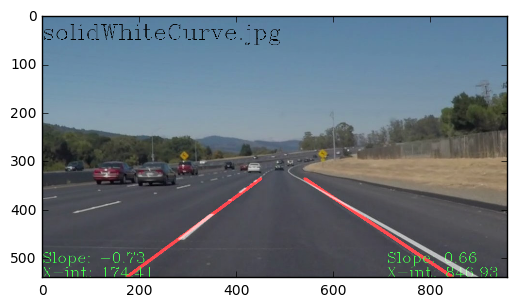

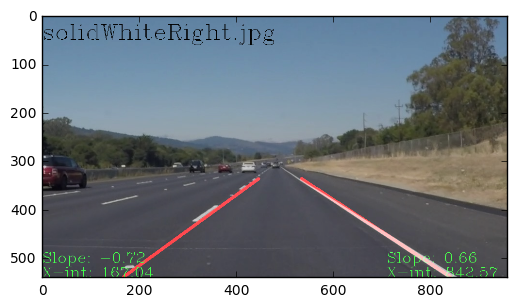

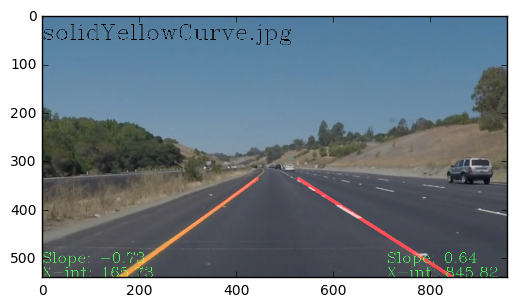

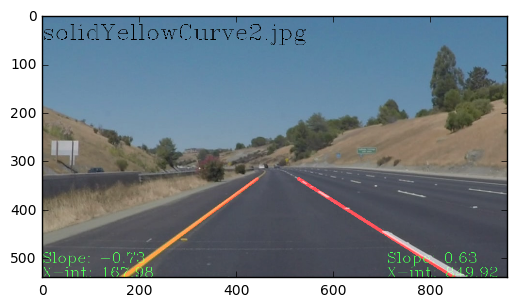

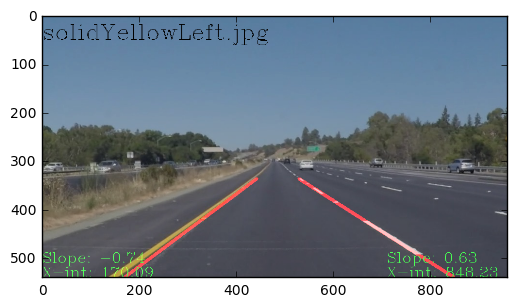

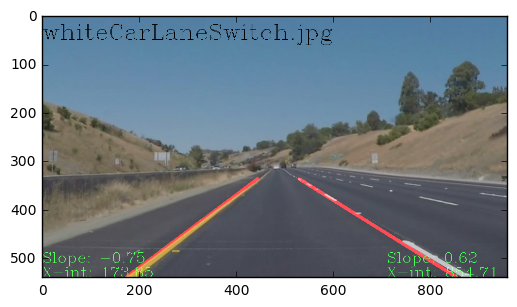

In [21]:
import os
testimages = os.listdir("test_images/")

for FNimage in testimages:
    plt.figure()
    image = process_image(mpimg.imread("test_images/" + FNimage))
    cv2.putText(image, FNimage, org=(0, 50), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1.5, color=(0,0,0))
    plt.imshow(image)

---
## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:11<00:00, 19.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 12 s


In [24]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:36<00:00, 18.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 37.7 s


In [25]:
#initial guess
kalman_slope_left = -0.7
kalman_P1_left = 1E-2
kalman_xint_left =  220
kalman_P2_left = 1E-2

kalman_slope_right = 0.7
kalman_P1_right = 1E-2
kalman_xint_right =  1120
kalman_P2_right = 1E-2

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:23<00:00, 11.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 25.6 s


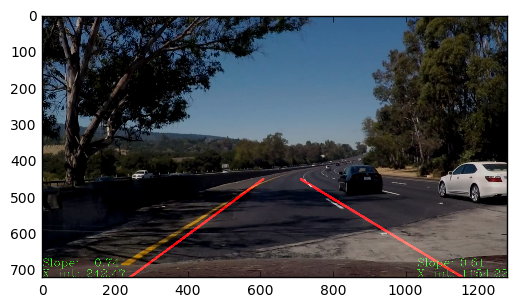

In [26]:
clip1 = VideoFileClip('challenge.mp4')
myframe = clip1.get_frame(5.9)
newImage = process_image(myframe)
plt.imshow(newImage)

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

## Note: This video is 1280x720